# Конспект по нейронным сетям

<a id='contents'></a>
Содержание:

- <a href='#base'>Базовые понятия</a>
- <a href='#frameworks'>Фреймворки</a> 
- <a href='#linear'>Линейная модель</a>
- <a href='#perceptron'>Перцептрон. Однослойный, многослойный (история)</a>
- <a href='#fc'>Полносвязный слой</a>
- <a href='#activation'>Функции активации</a>
- <a href='#initialisation'>Инициализация весов</a>
- <a href='#gradients'>Градиентный спуск</a>
- <a href='#loss'>Функционал ошибки и его виды</a>
- <a href='#norm'>Нормализация</a>
- <a href='#dropout'>Дропаут</a>
- <a href='#smoothing'>Label smoothing</a>
- <a href='#conv'>CNN, сверточный слой</a>

**Нейронная сеть** &ndash; это граф вычислений (DAG, Directed Acyclic Graph) 

То есть, по сути, мы просто собираем кучу функций в один связный направленный граф, по которому машина потом считает. 

*Императивный подход* vs *символьный подход*:

- в императивном подходе сразу считаем все
- в символьном подходе сперва задаем граф вычислений, а потом считаем

Выгода заранее заданного графа вычислений: некоторые вещи (градиенты) не приходится считать по мильену раз. 

<a id='base'></a>
***

**Базовые понятия**

Граф вычислений &ndash; структура, по которой будет вычисляться сеть

Нейрон &ndash; линейная функция, получающая данные на вход, преобразующая их ($w \cdot x + b$) и возвращающая результат

Функция активации &ndash; (нелинейная) функция, которая преобразует выходящий из нейрона сигнал

Веса сети &ndash; или *параметры*: те самые $w_i$, все, что должно изменяться в процессе обучения с помощью градиентного спуска

Слой &ndash; набор нейронов, которые все получают одни инпуты и выдают какие-то аутпуты через функцию активации

forward (прямой проход) &ndash; пробрасывание каких-то данных на вход через весь граф вычислений

backprop(agation), бэкпроп &ndash; вычисление градиентов для обновления весов сети

Функционал ошибки (loss) &ndash; разница между предсказанным и истинным ответом, может быть выражена разными функциями (для разных задач)

Метрика &ndash; способ оценки качества работы НС, может совпадать по формуле с лоссом, но не обязано

Градиентный спуск &ndash; метод поиска минимума функции потерь (loss)

<a href='#contents'>К содержанию</a>

<a id='frameworks'></a>
***

**Фреймворки**:

- Tensorflow + Keras: [тетрадка по керасу](kerasman.ipynb)
- PyTorch: [тетрадка по торчу](torchman.ipynb), а также [тетрадка по ignite](igniteman.ipynb) &ndash; библиотеке над торчом
- AllenNLP

[Статья на хабре про разницу между ними и про торч](https://habr.com/ru/post/334380/)

*Фиксированные модули*. Такой подход можно сравнить с конструктором Lego: пользователь комбинирует заранее определённые блоки в граф вычислений и запускает его. Прямой и обратный проходы уже зашиты в каждом таком блоке. Определение новых блоков гораздо сложнее использования готовых и требует совершенно иных знаний и умений. Расширяемость близка к нулю, однако если ваши идеи полностью реализуются в таком фреймворке, скорость разработки максимальна. Со скоростью работы, благодаря высокой оптимизированности заранее написанного кода, также не возникает проблем. Типичные представители: Caffe, Caffe2, CNTK, Kaldi, DL4J, Keras (как интерфейс).

*Статический граф вычислений*. Эти фреймворки уже можно сравнить с полимерной глиной: на этапе описания возможно создать граф вычислений произвольного размера и сложности, однако после запекания (компиляции) он станет твёрдым и монолитным. Доступными останутся всего два действия: запустить граф в прямом или обратном направлениях. Все такие фреймворки используют декларативный стиль программирования и напоминают функциональный язык или математическую нотацию. С одной стороны, этот подход комбинирует гибкость на этапе разработки и скорость в момент исполнения. С другой стороны, как и в функциональных языках, отладка становится настоящей головной болью, а модели, выходящие за рамки парадигмы, требуют либо титанических усилий, либо здоровенных костылей для реализации. Представители: Theano, TensorFlow, MXNet.

*Динамический граф вычислений*. Представьте теперь, что вы можете перестраивать статический граф перед каждым его запуском. Примерно это и происходит в данном классе фреймворков. Только графа как отдельной сущности здесь нет. Он, как и в императивных языках программирования, слишком сложен для явного построения и существует лишь в в момент исполнения. Точнее сказать, граф строится динамически каждый раз при прямом проходе для того, чтобы затем иметь возможность сделать проход обратный. Подобный подход даёт максимальную гибкость и расширяемость, позволяет использовать в вычислениях все возможности используемого языка программирования и не ограничивает пользователя вообще ничем. К этому классу фреймворков как раз и относятся Torch и PyTorch.

<a href='#contents'>К содержанию</a>

<a id='linear'></a>
***

#### Немного повторения про машинное обучение и в частности про линейные модели

**Линейная модель** &ndash; мы пытаемся построить линейную зависимость между признаками и *целевой переменной* (*ground truth*, $\hat{y}$) вида $w \cdot x + b = y$ путем настраивания *весов* $w_1, w_2, ..., w_n$ и *свободного коэффициента*, он же смещение, он же bias $w_0$. Как настроить веса? У нас есть некоторый *функционал ошибки*, н-р, $MSE = \frac{1}{n}\sum\limits_{i=1}^{n}(Y_i - \hat{Y_i})^2$, то есть, некая разница между предсказанным y и истинным y. Мы должны эту разницу минимизировать. Это уравнение может решаться в матричном виде как $w = (X^T \cdot X)^{-1} \cdot X^T \cdot y$ &ndash; это *аналитическое решение*. Его недостатки: 1) вычислительно дорого 2) имеет решение не для всякого функционала ошибки.

Обычно задачу минимизации функционала ошибки решают с помощью *градиентного спуска*. Это *аппроксимация* (поэтому иногда про НС говорят, что это аппроксиматоры), то есть, мы не хотим точно найти ответ на наше уравнение, а только приблизительно. Идея градиентного спуска в том, что касательная к функции в точке $x$ указывает направление ее возрастания (вектор градиента), а антиградиент (т.е. градиент с минусом) &ndash; убывания. Мы находим частные производные по всем весам, которые хотим обновить, и вычитаем их из первоначальных весов. 

**Причем тут нейронки?**

А притом, что НС &ndash; это по существу много скомпонованных линейных моделей. 

<a href='#contents'>К содержанию</a>

<a id='perceptron'></a>
***

#### Перцептроны. Немного истории

Перцептрон предложил Ф. Розенблатт в 1957 году в одноименной книге. Схема перцептрона выглядит примерно так:

<img src='img/1.PNG' width='400'>

Перцептрон получает несколько сигналов, домножает их на веса, складывает со смещениями и потом складывает то, что получилось; если получившаяся сумма больше какого-то порога, сигнал проходит, если нет &ndash; то нет. Соответственно, функция активации перцептрона переводит аутпут в бинарное (-1;1). Это может быть функция шага, знака или сигмоида. 

<img src='img/2.PNG' width='400'>

[Алгоритм обучения перцептрона](https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975) был не такой, как сегодня в нейронках:

<img src='https://miro.medium.com/max/1032/1*PbJBdf-WxR0Dd0xHvEoh4A.png' width='400'>
     


Вот перцептрон с сигмоидой и градиентным спуском &ndash; это уже близко к реальности. Но в 1969 году Марвин Минский с соавтором доказал, что такой одинокий перцептрон не справляется с нелинейными данными. Ну то есть, перцептрон &ndash; это все равно линейная модель, которая не умеет ничего, кроме рисования полосочек. Но что, если взять несколько полосочек и совместить их? 

Окей, если мы возьмем два нейрона (без активации) и тупо их соединим, или хоть два миллиона, на самом деле это все равно будет линейная модель, потому что можно уравнения преобразовать, раскрыть там скобочки и все равно получить условное $k \cdot x + b$. Но если между ними добавятся нелинейные функции активации, то уже схлопнуть все в линейную модель не получится. 

Соответственно, многослойный перцептрон (Multilayer Perceptron, MLP) &ndash; самый простой вариант полноценной нейронной сетки, который состоит из нескольких слоев, сообщающихся друг с другом. Эти слои:

- входной слой (input layer), тот, который получает данные на вход;
- скрытые слои (hidden layers), все, что между входом и выходом;
- выходной слой (output layer), выдает результат. 

Тут уже пора перейти к типам слоев. 

<a href='#contents'>К содержанию</a>

<a id='fc'></a>
***

#### Полносвязный слой (Fully connected, FC, Linear)

Полносвязный слой &ndash; это такой слой нейронов, где выходы из *всех* нейронов (предыдущего слоя) приходят на вход ко *всем* нейронам. 

- на входе $n$ чисел, на выходе $m$ чисел. Они необязательно совпадают, может быть любое больше или меньше другого;
- $x_1, x_2, ..., x_n$ &ndash; входы;
- $z_1, z_2, ..., z_m$ &ndash; выходы;
- Каждый выход &ndash; линейная модель над входами:

$z_j = \sum\limits_{i=1}^{n}w_{ji}x_i + b_i$

Итого в полносвязном слое $m \cdot n$ параметров. Выглядит он так:

<img src='img/fc.PNG' width='300'>

Вообще видов слоев очень много:

<img src='img/torchlayers.PNG' width='600'>

<a href='#contents'>К содержанию</a>

<a id='activation'></a>
***

## Функции активации

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math

def funcplot(func, name):
    x = np.linspace(-5, 5, 50)
    z = func
    fig, ax = plt.subplots()
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_ylim([-1, 1])
    plt.xlabel('x')
    plt.ylabel(name)
    ax.plot(x, z, '-c')

    plt.show()

Итак, на выходах каждого слоя НС обязательно должна быть функция активации. Она должна быть нелинейная (чтобы сеть могла работать с нелинейными данными) и желательно дифференцируемая: потому что когда мы делаем бэкпроп, мы считаем производные и для функции активации тоже. 

[Полный список на вики](https://en.wikipedia.org/wiki/Activation_function)

Классическая функция активации &ndash; сигмоида: $\sigma(x) = \frac{1}{1 + e^{-x}}$

График сигмоиды, как известно:

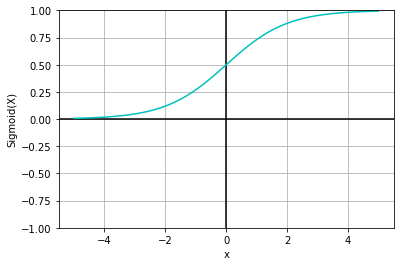

In [11]:
funcplot(1/(1 + np.exp(-x)), 'Sigmoid(X)')

Хорошая нелинейная функция, ее основной недостаток &ndash; на больших по модулю значениях, типа (-)100, ее касательная будет практически лежать, а значит, градиент будет очень маленьким числом. Этот артефакт называется *затухание градиентов* и для больших архитектур делает сигмоиду непригодной (может наступить *паралич сети*).

Соответственно, недостатки сигмоиды:
 
- <font color='red'>Затухание градиента</font>
- <font color='red'>Не центрирована относительно нуля</font>
- <font color='red'>Вычислять градиент дорого</font>

Другой вариант активации &ndash; тангенс tanh:

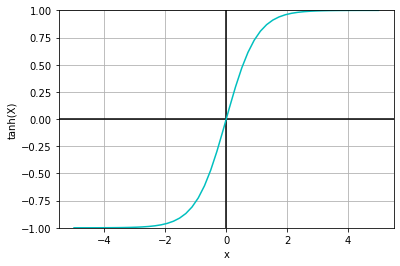

In [12]:
funcplot((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)), 'tanh(X)')

- <font color='green'>Центрирован относительно нуля</font>
- <font color='red'>Все еще похож на сигмоиду</font>
- <font color='red'>Все равно будет затухать градиент, даже еще сильнее</font>

Куда лучше ReLU (Rectified linear unit (ReLU), который выглядит следующим образом:

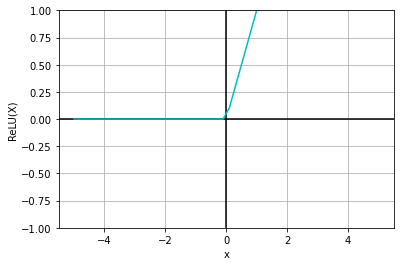

In [13]:
funcplot(np.maximum(x, 0), 'ReLU(X)')

- <font color='green'>Быстро вычисляется</font>
- <font color='green'>Градиент не затухает</font>
- <font color='green'>Сходимость сеток ускоряется</font>
- <font color='red'>Сетка может умереть, если активация занулится на всех нейронах</font>
- <font color='red'>Не центрирован относительно нуля</font>
- <font color='red'>Если $w_0$ инициализировано большим отрицательным числом, нейрон сразу умирает ⇒ надо аккуратно инициализировать веса</font>

Leaky ReLU:

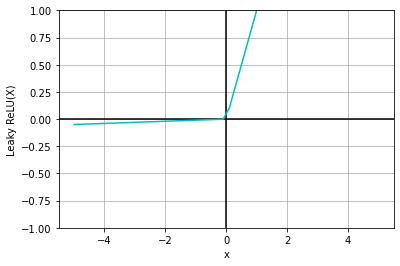

In [14]:
a = 0.01
funcplot(np.maximum(a * x, x), 'Leaky ReLU(X)')

- <font color='green'>Как ReLU, но не умирает, всё ещё легко считается</font>
- <font color='green'>Производная может быть любого знака</font>
- Важно, чтобы 𝑎 ≠ 1, иначе линейность

**Как выбирать функцию активации?**

- Обычно начинают с *ReLU*, если сетка умирает, берут *LeakyReLU*
- *ReLU* &ndash; стандартный выбор для свёрточных сетей
- В рекуррентных сетках чаще всего предпочитается *tanh*
- На самом деле это не очень важно, нужно держать в голове свойства функций, о которых выше шла речь, и понимать, что от перебора функций обычно выигрыш в качестве довольно низкий
- Но есть и исключения ...

[Статья с обзором на архиве](https://arxiv.org/pdf/1804.02763.pdf)

<a href='#contents'>К содержанию</a>

<a id='initialisation'></a>
***

## Инициализация весов

От инициализации весов иногда многое зависит (см. выше, нейронка может с места в карьер сдохнуть). Обычно стремятся уменьшить симметрию и инициализируют рандомными числами из какого-нибудь распределения (нормальное, равномерное). 

Наши признаки 𝑋 пришли к нам из какого-то распределения. Выход слоя 𝑓(𝑋𝑊) будет принадлежать другому распределению. Если инициализировать веса неправильно, дисперсия распределения может от слоя к слою затухать (сигнал будет теряться) либо наоборот, возрастать (сигнал будет рассеиваться). Эмпирически было выяснено, что это может портить сходимость для глубоких сеток. Хочется контролировать дисперсию.

**Симметричный случай**

В симметричном случае распределение может быть таким:

![Distribution](img/6.PNG)

(как это читать: диаграммы показывают распределение выходов слоя слева направо, т.е. левые диаграммы после первого слоя, правые &ndash; с конца). 

Выход нейрона перед активацией такой:

$h_i = w_0 + \sum\limits_{i=1}^{n_{in}}w_i \cdot x_i$

Дисперсия $h_i$ выражается через дисперсии $x$ и $w$, не зависит от константы $w_0$. Как ее вывести:

$h = x \cdot w$ (векторное представление)

$Var(h) = E(h - E(h)^2) = E((x \cdot w - E(x \cdot w)^2)$ (по определению)

$E(x_ \cdot w) = E(x) \cdot E(w)$

Подставим

$Var(h) = E(x^2 \cdot w^2 - 2 \cdot x \cdot w \cdot E(x) \cdot E(w) + E(x)^2 \cdot E(w)^2)$

$Var(h) = E(x^2) \cdot E(w^2) - 2 \cdot E(x)^2 \cdot E(w)^2 + E(x)^2 + E(w)^2$

С другой стороны, по определению, любая дисперсия любой величины у:

$Var(y) = E(y^2) - E(y)^2$ ⇒ $E(y^2) = Var(y) + E(y)^2$

Подставляем

$Var(h) = (Var(x) + E(x)^2) \cdot (Var(w) + E(w)^2) - E(x)^2 \cdot E(w)^2$

Раскроем скобки

$Var(h) = Var(x) \cdot Var(w) + Var(x) \cdot E(w)^2 + E(x)^2) \cdot Var(w) + \color{red}{E(x)^2 \cdot E(w)^2 - E(x)^2 \cdot E(w)^2}$

Выделенная красным часть самоуничтожится, и получится (если уже не в векторном представлении):

$Var(h_i) = Var(\sum\limits_{i=1}^{n_{in}}w_i \cdot x_i) = \sum\limits_{i=1}^{n_{in}}Var(w_i \cdot x_i) = \sum\limits_{i=1}^{n_{in}}[E(x_i)]^2 \cdot Var(w_i) + [E(w_i)]^2 \cdot Var(x_i) + Var(x_i) \cdot Var(w_i)$

Если функция активации предыдущего слоя симметричная, тогда матожидание икса = 0 ($E(x_i) = 0$). Будем инициализировать веса с нулевым средним, тогда и $E(w_i) = 0$.

$Var(h_i) = Var(\sum\limits_{i=1}^{n_{in}}w_i \cdot x_i) = \sum\limits_{i=1}^{n_{in}}Var(w_i \cdot x_i) = \sum\limits_{i=1}^{n_{in}}[E(x_i)]^2 \cdot Var(w_i) + [E(w_i)]^2 \cdot Var(x_i) + Var(x_i) \cdot Var(w_i) = \sum\limits_{i=1}^{n_{in}} Var(x_i) \cdot Var(w_i) = Var(x_i) \cdot [n_{in} \cdot Var(w_i)]$

$ [n_{in} \cdot Var(w_i)] = 1 $ &ndash; нужно, чтобы так было, чтобы дисперсия выхода была примерно равна дисперсии входа

Тогда, например, если мы берем первоначальные веса из распределения вида $U\left[ -\frac{\sqrt{3}}{\sqrt{n_{in}}}; \frac{\sqrt{3}}{\sqrt{n_{in}}} \right]$, то дисперсия будет равна $Var(w_i) = \frac{1}{12} \left( -\frac{\sqrt{3}}{\sqrt{n_{in}}} + \frac{\sqrt{3}}{\sqrt{n_{in}}} \right)^2 = \frac{1}{n_{in}} = 1$.

При этом при forward pass на вход идет $n_{in}$ наблюдений, а на backward &ndash; $n_{out}$ градиентов ⇒ канал с дисперсией может быть непостоянным, если число весов от слоя к слою сильно колеблется. Для неодинаковых размеров слоёв невозможно удволетворить обоим условиям, поэтому обычно усредняют: $U\left[ -\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}; \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}} \right]$. Такая инициализация называется <font color='green'>инициализация Ксавье Глоро</font>. [Статья Глоро тут](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

**Несимметричный случай**

Для несимметричного случая распределение может выглядеть так:

<img src='img/7.PNG' width='600'>

Формула та же самая, но когда нет симметрии, можно занулить только второе слагаемое:

$Var(h_i) = Var(\sum\limits_{i=1}^{n_{in}}w_i \cdot x_i) = \sum\limits_{i=1}^{n_{in}}[E(x_i)]^2 \cdot Var(w_i) + [E(w_i)]^2 \cdot Var(x_i) + Var(x_i) \cdot Var(w_i) =  \sum\limits_{i=1}^{n_{in}}Var(w_i) \cdot E(x_i^2) = E(x_i^2) \cdot \color{green}{[n_{in} \cdot Var(w_i)]}$

Инициализация, которая подходит для несимметричного случая &ndash; <font color='green'>инициализация Хе</font>. [Статья тут](https://arxiv.org/pdf/1502.01852.pdf).

Все эти сложные математические пируэты ведут, собственно, к главному выводу:

- Для симметричных функций с нулевым средним нужно использовать инициализацию Ксавье init="glorot_uniform";
- Для ReLU и им подобным инициализацию Хe init="he_uniform" или init="he_normal".

Эти две инициализации корректируют параметры распределений в зависимости от входа и выхода слоя так, чтобы поддерживать дисперсию равной единице.

Пример кода для Keras:

In [ ]:
def get_new_model():
    acc = Accuracy()
    
    model = Sequential([
        L.Dense(5, input_dim=X_train.shape[1], kernel_initializer='he_normal', activation='relu'),
        L.Dense(5, kernel_initializer='he_normal', activation='relu'),
        L.Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid')
    ])

Пример кода для torch (инициализация Кайминга = инициализация Хе, чувака звали Kaiming He и он китаец, поэтому никто не понял, что из этого фамилия...):

In [ ]:
class FeedforwardNeuralNetModel_with_Kaiming(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel_with_Kaiming, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Linear weight, W,  Y = WX + B
        nn.init.kaiming_normal_(self.fc1.weight)
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out

<a href='#contents'>К содержанию</a>

<a id='gradients'></a>
***

## Градиентный спуск и его виды

Как считать градиенты. 

Положим, у нас сетка состоит из двух слоев, на каждом слое один нейрон с одним весом и одним смещением, а между нейронами ReLU. То есть, так:

1). $h_1 = w_1 \cdot x + b_0$ ; 2). $ h_{r} = ReLU(h_1) $ ; 3). $ out = h_{r} \cdot w_1 + b_2 $

Как посчитать градиенты для такой сетки?

$L = (y - out)^2$ &ndash; функционал ошибки MSE

Градиент для Loss:

$ \frac{\partial L} {\partial out}  = 2 \cdot (out - y)$

Для $w_2$ и $b_2$:

$ \frac {\partial L} {\partial w_2} = \frac {\partial L} {\partial out} \cdot \frac {\partial out} {\partial w_2} = 2 \cdot (out - y) \cdot h_r^T$

$ \frac {\partial L} {\partial b_2} = \frac {\partial L} {\partial out} \cdot \frac {\partial out} {\partial b_2} = 2 \cdot (out - y) \cdot 1 $ &ndash; так как производная по $b_2$ = $ (const) + \color{red}{b_2} = 1$

Для $w_1$ и $b_1$:

$\frac {\partial L} {\partial w_1} = \frac {\partial L} {\partial out} \cdot \frac {\partial out} {\partial h_r} \cdot \frac {\partial h_r} {\partial h_1} \cdot \frac {\partial h_1} {\partial w_1} = 2 \cdot (out - y) \cdot \frac {\partial out} {\partial h_r} \cdot \frac {\partial h_r} {\partial h_1} \cdot x^T $

$\frac {\partial L} {\partial b_1} = \frac {\partial L} {\partial out} \cdot \frac {\partial out} {\partial h_r} \cdot \frac {\partial h_r} {\partial h_1} \cdot \frac {\partial h_1} {\partial b_1} = 2 \cdot (out - y) \cdot \frac {\partial out} {\partial h_r} \cdot \frac {\partial h_r} {\partial h_1} \cdot 1 $ &ndash; так как производная по $b_1$ тоже = $(const) + \color{red}{b_1} = 1$

In [20]:
import torch

batch_size = 64
input_size = 3
hidden_size = 2
output_size = 1
dtype = torch.float
device = torch.device("cpu")

In [22]:
# Create random input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype)
y = torch.randn(batch_size, output_size, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype)
b1 = torch.randn(batch_size, hidden_size, device=device, dtype=dtype)
b2 = torch.randn(batch_size, output_size, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    h_1 = x.mm(w1) + b1
    h_relu = h_1.clamp(min=0)
    out = h_relu.mm(w2) + b2

    loss = (out - y).pow(2).sum().item() #MSE

    dloss_dout = 2 * (out - y)  # первая производная по лоссу

    grad_w2 = h_relu.t().mm(dloss_dout)
    grad_b2 = dloss_dout
    grad_hrelu = dloss_dout.mm(w2.t())
    grad_hrelu[h_1 < 0] = 0
    grad_w1 = x.t().mm(grad_hrelu)
    grad_b1 = grad_hrelu
 
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    if t % 100 == 99:
        print(f'Loss on iteration {t} = {loss}')

Loss on iteration 99 = 219.7015838623047
Loss on iteration 199 = 212.0009307861328
Loss on iteration 299 = 204.9124755859375
Loss on iteration 399 = 198.3756103515625
Loss on iteration 499 = 192.33839416503906


Стандартный градиентный спуск (gradient descent): $ w_i = w_{i-1} - \eta \cdot g(w_{i-1})$. Это формула для обновления веса $w_i$. $\eta$ &ndash; это шаг обучения, learning rate, обычно его выбирают довольно маленьким (типа 0.001).

- Полный градиентный спуск: считаем градиенты по всем элементам выборки
- Стохастический градиентный спуск (SGD): считаем градиенты на каждом шаге по одному элементы выборки
- Мини-батч градиентный спуск (mini-batch SGD): считаем градиенты на каждом шаге по батчу (набору элементов из выборки)

В чем разница? Есть теорема, что градиентный спуск обязательно сойдется, даже стохастический (просто это случится через миллион лет). Для классического простого случая, когда у нас функция выпуклая (не имеет локальных минимумов), быстрее и стабильнее всего сходится полный градиентный спуск. Стохастический будет сходиться медленнее (но вычислительно он гораздо легче), а по батчу &ndash; нечто среднее. 

1) <img src='img/3.PNG'> 2) <img src='img/4.PNG'> 3) <img src='img/5.PNG'>

Так будет выглядеть спуск для того самого классического случая (побаловаться можно [здесь](https://deeplearning.ai/ai-notes/optimization/)). В первом случае используем полный градиентный спуск со средней скоростью learning rate, во втором случае mini-batch SGD с большой скоростью, а в третьем &ndash; SGD с большой скоростью. 

В чем важность learning rate, а также какие проблемы могут возникнуть?

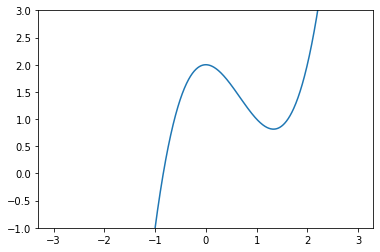

In [8]:
# Наша функция f(x)
func = lambda x: x ** 3 - 2 * x ** 2 + 2

# Производная функции f(x)
d_func = lambda x: 3 * x ** 2 - 4 * x

# Сделаем массив из 1000 элементов от -3 до 3
x = np.linspace(-3, 3, 1000)

# Определим границы по y для графика
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.show()

In [9]:
def find_minimum_first_order(
    learning_rate=0.01,
    eps=1e-4,
    max_iterations=1000,
    anneal_learning_rate=None
):
    '''Определим функцию для оптимизации, которая должна принимать на вход learning rate, максимальное количество итераций'''
    i = 0
    x_old, x_new = 0, 2
    # Будем сохранятся обновлённые значения x и y
    x_list, y_list = [x_old], [func(x_old)]
    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr
    # TODO:
    # Your code here
    # --------------
    while abs(x_new - x_old) > eps and i < max_iterations:
        # Получим learning rate для текущей итерации
        learning_rate = anneal_learning_rate(learning_rate, step=i)
        # Обновим x_old
        x_old = x_new
        # Сделаем один шаг gradient descent
        x_new = x_old - learning_rate * d_func(x_old)
        # Добавим новые значения для визуализации сходимости
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1
    # --------------
    print("Найденный локальный минимум:", x_new)
    print("Количество шагов:", len(x_list))
    # Визуализируем сходимость
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors='k')
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.show()

Найденный локальный минимум: 1.3577577123861129
Количество шагов: 729


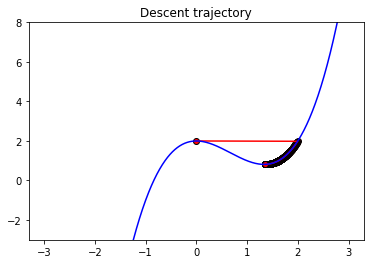

In [10]:
find_minimum_first_order(0.001)

Найденный локальный минимум: 1.3356881625009205
Количество шагов: 129


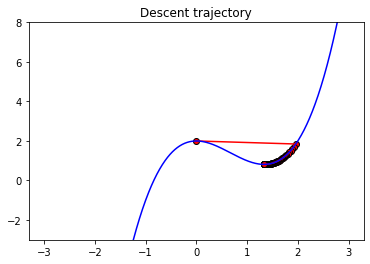

In [11]:
find_minimum_first_order(0.01)

Найденный локальный минимум: 1.3333495713163788
Количество шагов: 8


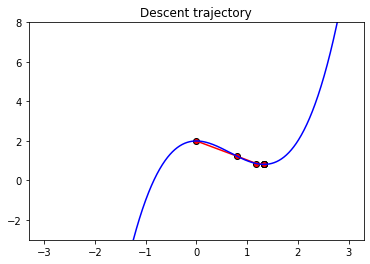

In [12]:
find_minimum_first_order(0.3)

Хотя большой learning rate опасен возможностью overflow (улетим в бесконечность), у него есть ряд преимуществ. Чем больше темп обучения, тем большие расстояния мы преодолеваем за один шаг и тем выше вероятность быстрее найти хорошее пространство локальных минимумов.

Хорошая стратегия — начинать с достаточно большого шага (чтобы хорошо попутешествовать по функции), а потом постепенно его уменьшать, чтобы стабилизировать процесс обучения в каком-то локальном минимуме.

Найденный локальный минимум: 1.294744839667743
Количество шагов: 7


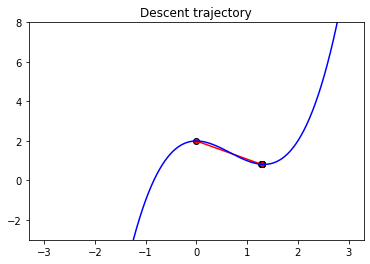

In [13]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3 * lr)

Описания ниже сперты у Кантонистовой

### SGD
SGD - этот же самый gradient descent, что мы рассматривали ранее, вот только подсчёт градиентов производится не по всему множеству данных, а по отдельно взятому сэмплу. Очевидно, такая оптимизация будет очень шумной, что усложнит обучение модели. Поэтому обычно используют MiniBatch-SGD, где вместо одного сэмпла мы берём $k$ семплов. У такого подхода есть несколько плюсов:

* ниже variance в сравнении с обычным SGD, что приводит к более стабильному процессу оптимизации
* хорошо работает с DL библиотеками, так как теперь мы работаем с матрицами

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

### SGD with Momentum

<img src="img/Momentum.png" width="600">

Попытаемся добавить SGD эффект инерции. Теперь, вместо того чтобы двигаться строго в направлении градиента в каждой точке, мы стараемся продолжить движение в том же направлении, в котором двигались ранее. То есть у нашей точки, которая спускается по многомерной поверхности, появляется импульс (momentum), который контролируется при помощи параметра $\alpha$. Он определяет какую часть прошлого градиента мы хотим использовать на текущем шаге.
$$
\begin{eqnarray}
g_{t} &=& \alpha g_{t-1} + \eta \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

### Nesterov

<img src='img/nesterov.PNG' width='500'>

Можно момент добавлять по-другому: 

$$
\begin{eqnarray}
\begin{cases}
m_{i + 1} &=& \beta m_i - \gamma \Delta f(w_i + \beta m_i) \\
w_{i + 1} &=& w_i + m_{i + 1}
\end{cases}
\end{eqnarray}
$$

## Адаптивные варианты градиентного спуска
Во всех предыдущих алгоритмах у нас был фиксированный learning rate. Начиная с Adagrad у нас будут идти алгоритмы, которые подстраивают learning rate в зависимости от обучения. Они называются адаптивными вариантами градиентного спуска.

Адаптивные варианты градиентного спуска подстраивает темп обучения таким образом, чтобы делать большие или маленькие обновления отдельных параметров. Например, может так сложиться, что некоторые веса близки к своим локальным минимумам, тогда по этим координатам нужно двигаться медленнее, а другие веса ещё только в середине, значит их можно менять гораздо быстрее. Подобные методы часты приводят к более обоснованной модели и сходятся гораздо быстрее.

### Adagrad
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& s + diag(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+eps}} \odot g
\end{eqnarray}
$$
Теперь нам не нужно сильно волноваться о правильном подборе $\eta$, так как $s$ контролирует скорость обучения для каждого параметра.

### RMSprop
У Adagrad есть сильный минус. $s$ - всегда положительна и постоянно растёт во время обучения, что приводит к ситуации, когда у нас learning rate становится слишком маленький, и мы перестаём учиться. RMSprop исправляет эту проблему при помощи экспоненциального сглаживания
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& \rho s + (1 - \rho) diag(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+eps}} \odot g
\end{eqnarray}
$$

### Adam
Добавим не только моменты второго порядка, но и первого при обновлении параметров
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

### AdamW

Это Адам с затуханием весов (weight decay). Подробнее можно прочитать [тут](https://towardsdatascience.com/why-adamw-matters-736223f31b5d).

### Схема
<div>
<img src="img/Modifications.png" width="300"/>
</div>

#### Размер батча

Yann LeCun утверждает, что чем больше батч, тем лучше, но экспериментально доказано, что совсем большие батчи могут ухудшить ситуацию. С чем это связано? Если поверхность функции потерь очень сложная с кучей локальных минимумов, на большом батче мы можем угодить в локальный минимум и не выскочим из него (типа, собрали все точки с окрестностей и они все указывают в него). Поэтому батч лучше брать побольше, но если что, можно пробовать и уменьшать. 

[Некоторая статеечка](https://arxiv.org/pdf/1711.00489.pdf)

Изменение размера батча vs learning rate

<a href='#contents'>К содержанию</a>

<a id='loss'></a>
***

### Функционал ошибки и его виды

тут пока пусто

<a href='#contents'>К содержанию</a>

<a id='norm'></a>
***

### Нормализация

Первоначальная проблема, с которой пытались бороться &ndash; Covariate Shift (изменение распределения данных). Объекты могут быть по-разному распределены на обучении и на тестировании, распределение может изменяться после прохождения очередного слоя (internal covariate shift). 

Придумали для этого делать Batch Normalisation:

- Реализуется как отдельный слой
- Вычисляется для текущего батча
- Оценим среднее и дисперсию каждой компоненты входного вектора: 

$$\mu_B = \frac{1}{n} \sum\limits_{j=1}^{n}x_{B,j}$$

$$\sigma_B^2 = \frac{1}{n} \sum\limits_{j=1}^{n}(x_{B,j} - \mu_B)^2 : покоординатно$$ 

($x_{B,j}$ &ndash; j-й объект в батче

Отмасштабируем все выходы:

$$\tilde{x}_{B,j} = \frac{x_{B,j} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

Зададим нужные нам среднее и дисперсию:

$$z_{B,j} = \gamma \cdot \tilde{x}_{B,j} + \beta $$

Здесь $\gamma$ и $\beta$ &ndash; обучаемые параметры сети. 

Итого: 

- Обычно вставляется между полносвязным/свёрточным слоём и нелинейностью
- Позволяет увеличить длину шага в градиентном спуске
- *Не факт, что действительно устраняет covariance shift*

[Статья о нормализации](https://arxiv.org/pdf/1805.11604.pdf)

<a href='#contents'>К содержанию</a>

<a id='dropout'></a>
***

### Дропаут

Когда у нас мало данных и полносвязные слои, получается, что в сетке слишком много параметров и она сильно переобучается. Чтобы уменьшить переобучение в таком случае, можно сетке <s>дать молотком по башке</s> принудительно отключить часть нейронов, занулив их выходы. Это и называется dropout. Как это работает?

- Можно определить как слой $d(x)$
- Параметров нет, единственный гиперпараметр &ndash; $p$ (вероятность удаления нейрона)
- На этапе обучения: $d(x) = \frac{1}{p}m \cdot x$ (m &ndash; вектор того же размера, что и х, элементы берутся из распределения Бернулли)
- Деление на p нужно для сохранения суммарного масштаба выходов

[Статья про дропаут](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

Интерпретация: мы обучаем все возможные архитектуры нейросетей, которые получаются из исходной выбрасыванием отдельных нейронов. У всех этих архитектур общие веса. На этапе применения (почти) усредняем прогнозы всех этих архитектур.

<a href='#contents'>К содержанию</a>

<a id='smoothing'></a>
***

#### Label Smoothing

пока пусто

<a href='#contents'>К содержанию</a>

<a id='conv'></a>
***

## CNN и сверточные слои

пока пусто

<a href='#contents'>К содержанию</a>